## Tasks
1. plot seven categories vs. rent in NY and NJ (two plots) by county
https://docs.bokeh.org/en/2.2.3/docs/gallery/bar_mixed.html
（Done)

2. draw a diagram to show how I connect the data: recursion algorithm

3. adding NY's plot

4. write the whole story

5. Modify some web features

# Analyses on social-spatial data and gross rent

In [1]:
import numpy as np
import math
import collections
import pandas as pd
import pickle
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from IPython.display import GeoJSON

In [48]:
from bokeh.io import show, output_notebook, output_file
from bokeh.models import (FactorRange, CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider,
                          LinearAxis, Range1d, 
                          Toggle)
from bokeh.transform import dodge
from bokeh.layouts import column, row, widgetbox, layout
from bokeh.resources import CDN
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.models.widgets import Slider, Dropdown

output_notebook()

Loading BokehJS ...

## Data processing

- a dataframe with spatial factors and gross rent but without geoinfo

In [51]:
all_df = pd.read_parquet('data_aarp_census/nj_ny_merged_with_census.parquet')
ml = pd.read_pickle('all_data.pkl')

In [52]:
all_df = all_df.replace({'B25058_001E': {None: 0, -666666666.0: 0}})

In [53]:
all_df['B25058_001E'].isnull().sum()

0

In [54]:
# df = all_df[(all_df['B25058_001E'] > 0) & (all_df['total_score'] > 0)]
df = all_df.rename(columns={'B25058_001E': 'med_rent'})
df = df.drop(['up_mobile', 'engage_vol'], axis=1)

In [55]:
county_nj_ny = pd.read_csv('data_aarp_census/census/county_index.txt', delimiter= '\t', index_col=False, header=None, names=['state', 'county', 'county_name'], dtype=str)

In [56]:
df = df.merge(county_nj_ny, how='left', on=['state', 'county'])

- Subsets of integrated data for modeling

In [8]:
loc_rent = ['GEOID', 'state', 'county', 'tract', 'block group', 'county_name', 'med_rent']
tot_lst = ['total_score', 'engagement', 'environment', 'health', 'housing', 'opportunity', 'neighborhood', 'transportation']
demog = ['GEOID', 'median_inc', 'life_ex', 'pct_50plus', 'pct_65plus', 'pct_africa', 'pct_asian', 'pct_disabi', 'pct_hispan', 'pct_novehi', 'pct_povert']
hs = ['house_access', 'house_burden', 'house_cost', 'house_multifam', 'house_subsidy']
eng = ['engage_broad', 'engage_civic', 'engage_culture', 'engage_social', 'engage_vote']
env = ['env_air_qual', 'env_pollute', 'env_road', 'env_water']
hlth = ['health_exercise', 'health_hospital', 'health_obese', 'health_sate', 'health_short', 'health_smoke']
ngb = ['prox_activity', 'prox_auto', 'prox_land_use', 'prox_lib', 'prox_markets', 'prox_parks', 'prox_sec', 'prox_trans', 'prox_vacant']
trns = ['trans_access', 'trans_cost', 'trans_delay', 'trans_fatal', 'trans_freq', 'trans_speed_lim', 'trans_walk_trip']
opp = ['opp_age', 'opp_grad', 'opp_income', 'opp_jobs']

In [12]:
loc_df = df[loc_rent]

In [27]:
loc_df.head()

,GEOID,state,county,tract,block group,county_name,med_rent
0,340010107001,34,001,010700,1,Atlantic County,0.0
1,340010112011,34,001,011201,1,Atlantic County,917.0
2,340010112021,34,001,011202,1,Atlantic County,1201.0
3,340010112022,34,001,011202,2,Atlantic County,1417.0
4,340010112023,34,001,011202,3,Atlantic County,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002694EA6BDF0>]],
      dtype=object)

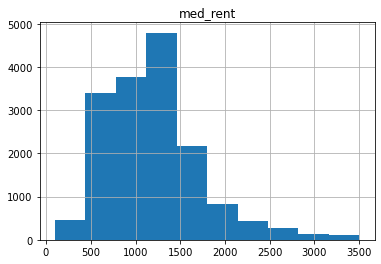

In [20]:
df.hist('med_rent')

- a datafram with geo info

In [57]:
gdf = gpd.read_file('data_aarp_census/nj_ny_geoid.geojson')
gdf = gdf.drop(['up_mobile', 'engage_vol'], axis=1)

In [58]:
# Merge geodata with rent data
gdf_rent = gdf.merge(loc_df, left_on = 'GEOID', right_on = 'GEOID')

In [ ]:
# merge the geo and rent data with pred_rent data
ml_lst = [59] + list(range(66, 93))
all_data = pd.merge(gdf_rent, ml.iloc[:, ml_lst], how='left', on='GEOID')
all_data = all_data.fillna(0)

In [70]:
# write the merged data (geo + aarp + rent)
all_data.to_pickle("./all_data.pkl")

## Vis on median rent distribution

In [4]:
# load the data with all columns and predictions
tot_gdf = pd.read_pickle('all_data.pkl')

In [18]:
loc_rent = ['GEOID', 'state', 'county', 'tract', 'block group', 'county_name', 'med_rent', 'geometry']
tot_lst = ['total_score', 'engagement', 'environment', 'health', 'housing', 'opportunity', 'neighborhood', 'transportation']
demog = ['GEOID', 'median_inc', 'life_ex', 'pct_50plus', 'pct_65plus', 'pct_africa', 'pct_asian', 'pct_disabi', 'pct_hispan', 'pct_novehi', 'pct_povert']
hs = ['house_access', 'house_burden', 'house_cost', 'house_multifam', 'house_subsidy']
eng = ['engage_broad', 'engage_civic', 'engage_culture', 'engage_social', 'engage_vote']
env = ['env_air_qual', 'env_pollute', 'env_road', 'env_water']
hlth = ['health_exercise', 'health_hospital', 'health_obese', 'health_sate', 'health_short', 'health_smoke']
ngb = ['prox_activity', 'prox_auto', 'prox_land_use', 'prox_lib', 'prox_markets', 'prox_parks', 'prox_sec', 'prox_trans', 'prox_vacant']
trns = ['trans_access', 'trans_cost', 'trans_delay', 'trans_fatal', 'trans_freq', 'trans_speed_lim', 'trans_walk_trip']
opp = ['opp_age', 'opp_grad', 'opp_income', 'opp_jobs']
metro_ny = ['Kings County', 'Queens County', 'Bronx County', 'New York County', 'Richmond County', 'Nassau County', 'Westchester County', 'Rockland County']
north_nj = ['Bergen County', 'Union County', 'Essex County', 'Hudson County', 'Morris County', 'Passaic County', 'Sussex County', 'Warren County']

In [6]:
# subset: seven main categories
main_gdf = tot_gdf[loc_rent + tot_lst]
# sub categories
sub_gdf = tot_gdf[loc_rent + eng + env + hlth + ngb + trns + opp]

In [23]:
tot_nj = main_gdf[tot_gdf['state'] == '34']
tot_ny = main_gdf[tot_gdf['state'] == '36']
nj_north = tot_nj[tot_nj['county_name'].isin(north_nj)]
ny_metro = tot_ny[tot_ny['county_name'].isin(metro_ny)]

In [22]:
pd.set_option('display.max_rows', 999)

- **Bar plot**

In [75]:
ch = tot_nj[['county_name','housing']]

In [88]:
# output_file("bar_mixed.html")
# nj_north['rent_tenth'] = nj_north['med_rent'] / 10
main_by_county = nj_north[['county_name', 'med_rent'] + tot_lst].groupby('county_name')
source = ColumnDataSource(main_by_county)

# colors = ('#440154', '#404387', '#29788E', '#22A784', '#79D151', '#DD4968', '#FD9F6C', '#FDE724')
colors = ('#440154', '#d73027', '#fc8d59', '#fee090', '#ffffbf', '#e0f3f8', '#91bfdb', '#4575b4')

p = figure(x_range=main_by_county, plot_width=900, plot_height=350, title='Northeast New Jersey Area', 
           x_axis_label='County', 
           y_axis_label='Livability Score', 
           toolbar_location=None, tooltips=[('median rents', '$''@med_rent_mean')])

p.y_range = Range1d(0, 120)
# p.vbar(x=dodge('county_name', -1, range=p.x_range), top='total_score_mean', width=0.2, source=source, color=colors[0])
p.vbar(x=dodge('county_name', -0.36, range=p.x_range), top='engagement_mean', width=0.1, source=source, color=colors[1], legend_label='engagement')
p.vbar(x=dodge('county_name', -0.24, range=p.x_range), top='environment_mean', width=0.1, source=source, color=colors[2], legend_label='environment')
p.vbar(x=dodge('county_name', -0.12, range=p.x_range), top='health_mean', width=0.1, source=source, color=colors[3], legend_label='health')
p.vbar(x=dodge('county_name', 0.0, range=p.x_range), top='housing_mean', width=0.1, source=source, color=colors[4], legend_label='housing')
p.vbar(x=dodge('county_name', 0.12, range=p.x_range), top='opportunity_mean', width=0.1, source=source, color=colors[5], legend_label='opportunity')
p.vbar(x=dodge('county_name', 0.24, range=p.x_range), top='neighborhood_mean', width=0.1, source=source, color=colors[6], legend_label='neighborhood')
p.vbar(x=dodge('county_name', 0.36, range=p.x_range), top='transportation_mean', width=0.1, source=source, color=colors[7], legend_label='transportation')

p.x_range.range_padding = 0.01
p.legend.location = 'top_left'
p.legend.orientation = 'horizontal'

# Add the median rent line
p.extra_y_ranges = {'rent': Range1d(start=100, end=2000)}
p.add_layout(LinearAxis(y_range_name='rent', axis_label='Median Rent'), 'right')

rent_line = p.line(x='county_name', y='med_rent_mean', color='darkolivegreen', line_width=1, line_dash='solid', source=source, y_range_name= 'rent')
toggle = Toggle(label='median rent by county', button_type="success", active=True)
toggle.js_link('active', rent_line, 'visible')

show(layout([p], [toggle]))

In [89]:
# output_file("bar_mixed.html")
# tot_ny['rent_tenth'] = tot_ny['med_rent'] / 10
main_by_county = ny_metro[['county_name', 'med_rent'] + tot_lst].groupby('county_name')
source = ColumnDataSource(main_by_county)

colors = ('#440154', '#d73027', '#fc8d59', '#fee090', '#ffffbf', '#e0f3f8', '#91bfdb', '#4575b4')

p = figure(x_range=main_by_county, plot_width=900, plot_height=350, title='Metro New York Area', 
           x_axis_label='County', 
           y_axis_label='Livability Score', 
           toolbar_location=None, tooltips=[('median rent', '$''@med_rent_mean')])

p.y_range = Range1d(0, 120)
# p.vbar(x=dodge('county_name', -1, range=p.x_range), top='total_score_mean', width=0.2, source=source, color=colors[0])
p.vbar(x=dodge('county_name', -0.36, range=p.x_range), top='engagement_mean', width=0.1, source=source, color=colors[1], legend_label='engagement')
p.vbar(x=dodge('county_name', -0.24, range=p.x_range), top='environment_mean', width=0.1, source=source, color=colors[2], legend_label='environment')
p.vbar(x=dodge('county_name', -0.12, range=p.x_range), top='health_mean', width=0.1, source=source, color=colors[3], legend_label='health')
p.vbar(x=dodge('county_name', 0.0, range=p.x_range), top='housing_mean', width=0.1, source=source, color=colors[4], legend_label='housing')
p.vbar(x=dodge('county_name', 0.12, range=p.x_range), top='opportunity_mean', width=0.1, source=source, color=colors[5], legend_label='opportunity')
p.vbar(x=dodge('county_name', 0.24, range=p.x_range), top='neighborhood_mean', width=0.1, source=source, color=colors[6], legend_label='neighborhood')
p.vbar(x=dodge('county_name', 0.36, range=p.x_range), top='transportation_mean', width=0.1, source=source, color=colors[7], legend_label='transportation')

p.x_range.range_padding = 0.01
p.legend.location = 'top_left'
p.legend.orientation = 'horizontal'

# Add the median rent line
p.extra_y_ranges = {'rent': Range1d(start=100, end=2000)}
p.add_layout(LinearAxis(y_range_name='rent', axis_label='Median Rent'), 'right')

rent_line = p.line(x='county_name', y='med_rent_mean', color='darkolivegreen', line_width=1, line_dash='solid', source=source, y_range_name= 'rent')
toggle = Toggle(label='median rent by county', button_type="success", active=True)
toggle.js_link('active', rent_line, 'visible')

show(layout([p], [toggle]))

- **Map plot**

In [422]:
tot_nyc = tot_ny[tot_ny['county_name'].isin(['Kings County', 'Queens County', 'Bronx County', 'New York County', 'Richmond County'])]

In [408]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = tot_nyc.to_json())

# Define color palettes
palette = brewer['Blues'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0',
 '500':'750', '1000':'1,000', 
 '1250':'1,250', '1500':'1,500',
 '1750':'1,750', '2000':'2,000', 
 '2250':'2,250', '2500':'2,500',
 '2750':'2,750', '3000':'3,000', 
 '3250':'3,250', '3500':'3,500',
 '3750':'3,750+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Median Rent in New York City, 2013-2018', 
           plot_height = 1500, plot_width = 1500, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
blockgroups = p.patches('xs','ys', source = geosource,
                   fill_color = {'field' :'med_rent',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p.add_tools(HoverTool(renderers = [blockgroups],
                      tooltips = [('NeighborID','@GEOID'),
                               ('Median Rent', '@med_rent')]))
# Specify layout
p.add_layout(color_bar, 'below')
show(p)

In [424]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = tot_nyc.to_json())

# Define color palettes
palette = brewer['Purples'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 100)
# Define custom tick labels for color bar.
tick_labels = {'0': '0',
 '10':'10', '20':'20', 
 '30':'30', '40':'40',
 '50':'50', '60':'60', 
 '70':'70', '80':'80',
 '90':'90', '100':'100'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Neighborhood Ratings in New York City', 
           plot_height = 1500, plot_width = 1500, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
blockgroups = p.patches('xs','ys', source = geosource,
                   fill_color = {'field' :'neighborhood',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p.add_tools(HoverTool(renderers = [blockgroups],
                      tooltips = [('NeighborID','@GEOID'),
                               ('Neighborhood Rating', '@neighborhood')]))
# Specify layout
p.add_layout(color_bar, 'below')
show(p)

In [392]:
tot_ny.describe()

,med_rent,engagement,environment,health,housing,neighborhood,opportunity,transportation
count,11942.000000,11942.000000,11942.000000,11942.000000,11942.000000,11942.000000,11942.000000,11942.000000
mean,1176.590437,48.436861,54.867275,50.028638,48.609111,66.653408,46.050410,71.961480
std,563.295446,11.019149,13.535150,13.617012,16.302530,18.569449,15.441686,21.239724
min,99.000000,19.000000,5.000000,18.000000,0.000000,17.000000,0.000000,20.000000
25%,717.000000,41.000000,47.000000,39.000000,38.000000,54.000000,36.000000,53.000000
50%,1140.000000,47.000000,58.000000,51.000000,48.000000,70.000000,45.000000,75.000000
75%,1458.000000,56.000000,66.000000,58.000000,57.000000,82.000000,57.000000,91.000000
max,3501.000000,85.000000,81.000000,83.000000,100.000000,100.000000,89.000000,100.000000


In [ ]:
x, y
p_df = lead_sites_geo.drop(‘geometry’, axis = 1).copy()
sitesource = ColumnDataSource(p_df)

In [ ]:
# Make a slider object to toggle the month shown
slider = Slider(title = 'Neighborhood', 
                start = 10, end = 100, 
                step = 1, value = 10)

In [ ]:
# This callback triggers the filter when the slider changes
callback = CustomJS(args = dict(source=sitesource), 
                    code = """source.change.emit();""")
slider.js_on_change('value', callback)
# Creates custom filter that selects the rows of the month based on the value in the slider
custom_filter = CustomJSFilter(args = dict(slider = slider, 
                                           source = sitesource), 
                               code = """
var indices = [];
// iterate through rows of data source and see if each satisfies some constraint
for (var i = 0; i < source.get_length(); i++){
 if (source.data[‘Month’][i] == slider.value){
 indices.push(true);
 } else {
 indices.push(false);
 }
}
return indices;
""")
# Uses custom_filter to determine which set of sites are visible
view = CDSView(source = sitesource, filters = [custom_filter])

In [ ]:
# Plots the water sampling sites based on month in slider
sites = p.circle('x', 'y', source = sitesource, color = 'red', 
                 size = 5, alpha = 0.3, view = view)
# Add hover tool
p.add_tools(HoverTool(renderers = [sites],
                      tooltips = [('Organization', '@OrganizationFormalName'),
                                  ('Location Type', '@MonitoringLocationTypeName'),
                                  ('Date', '@ActivityStartDate'),
                                  ('Lead (ug/l)', '@LeadValue_ug_l')]))
# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p, widgetbox(slider))
show(layout)